# First steps

## Importing libraries

In [302]:
#Import all required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from tqdm import tnrange, tqdm_notebook
from itertools import combinations
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import copy

## Reading in files

In [325]:
#Read in required files
store=pd.read_csv('store.csv')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train['Date']=pd.to_datetime(train['Date'],yearfirst=True)
test['Date']=pd.to_datetime(test['Date'],yearfirst=True)

## Merging the datasets

In [306]:
#Merge the datasets
merged_dataset=pd.merge(train,store,on='Store',how='left')
test=pd.merge(test,store,on='Store',how='left')
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [327]:
test=pd.merge(test,store,on='Store',how='left')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Store                        41088 non-null  int64         
 1   DayOfWeek                    41088 non-null  int64         
 2   Date                         41088 non-null  datetime64[ns]
 3   Sales                        0 non-null      float64       
 4   Customers                    0 non-null      float64       
 5   Open                         41077 non-null  float64       
 6   Promo                        41088 non-null  int64         
 7   StateHoliday                 41088 non-null  object        
 8   SchoolHoliday                41088 non-null  int64         
 9   StoreType_x                  41088 non-null  object        
 10  Assortment_x                 41088 non-null  object        
 11  CompetitionDistance_x        40992 non-nu

# Data Pre-processing

## Adding new columns

In [309]:
#Add new columns
merged_dataset['CurrentWeekOfYear']=merged_dataset['Date'].dt.isocalendar().week
merged_dataset['CurrentYear'] = pd.DatetimeIndex(merged_dataset['Date']).year
merged_dataset['CurrentMonth'] = pd.DatetimeIndex(merged_dataset['Date']).month
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

## Processing existing columns

In [310]:
#Adjust Promo2 for timing
merged_dataset["Promo2"]=np.where((merged_dataset['CurrentYear']< merged_dataset['Promo2SinceYear'])|((merged_dataset['CurrentYear']==merged_dataset['Promo2SinceYear']) & (merged_dataset['CurrentWeekOfYear']<merged_dataset['Promo2SinceWeek'])) ,0,merged_dataset['Promo2'])
merged_dataset.loc[merged_dataset['Promo2']==0,['Promo2SinceWeek','Promo2SinceYear','PromoInterval']]=np.nan

#Adjust CompetitionDistance for timing
merged_dataset["CompetitionDistance"]=np.where((merged_dataset['CurrentYear']<merged_dataset['CompetitionOpenSinceYear'])|((merged_dataset['CurrentYear']==merged_dataset['CompetitionOpenSinceYear']) & (merged_dataset['CurrentMonth']<merged_dataset['CompetitionOpenSinceMonth'])) ,np.nan,merged_dataset['CompetitionDistance'])
merged_dataset.loc[merged_dataset['CompetitionDistance'].isnull(),['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']]=np.nan


## Handling missing values

In [311]:
#Check for missing values
merged_dataset.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance           86275
CompetitionOpenSinceMonth    406981
CompetitionOpenSinceYear     406981
Promo2                            0
Promo2SinceWeek              576915
Promo2SinceYear              576915
PromoInterval                576915
CurrentWeekOfYear                 0
CurrentYear                       0
CurrentMonth                      0
dtype: int64

In [312]:
#Handle promo details missing values
merged_dataset.loc[merged_dataset['PromoInterval'].isna(), 'PromoInterval'] = "NotApplicable"
merged_dataset.loc[merged_dataset['Promo2SinceYear'].isna(), 'Promo2SinceYear'] = dt.now().year
merged_dataset.loc[merged_dataset['Promo2SinceWeek'].isna(), 'Promo2SinceWeek'] = dt.now().isocalendar()[1]

#Handle competition details missing values
merged_dataset.loc[merged_dataset['CompetitionOpenSinceMonth'].isna(), 'CompetitionOpenSinceMonth'] = dt.now().month
merged_dataset.loc[merged_dataset['CompetitionOpenSinceYear'].isna(), 'CompetitionOpenSinceYear'] = dt.now().year

In [313]:
#Function for competitiondistance missing values
def fillcompetitiondistance(fromdataset,todataset,column,storemodel):
    mean = round(fromdataset.loc[(fromdataset['StoreType'] == storemodel),column].mean(), 1)
    todataset.loc[todataset['StoreType'] == storemodel] = todataset.loc[todataset['StoreType'] == storemodel].fillna(value={column : mean})
    
#Handle competitiondistance missing values
storetype=['a','b','c','d']
for storemodel in storetype:
    fillcompetitiondistance(store,merged_dataset,'CompetitionDistance',storemodel)
    

In [314]:
#After handling missing values
merged_dataset.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
CurrentWeekOfYear            0
CurrentYear                  0
CurrentMonth                 0
dtype: int64

In [315]:
merged_dataset['StateHoliday'].replace(['0',0],['None','None'],inplace=True)

# Exploratory Data Analysis

Sales           AxesSubplot(0.125,0.53;0.352273x0.35)
Customers    AxesSubplot(0.547727,0.53;0.352273x0.35)
dtype: object

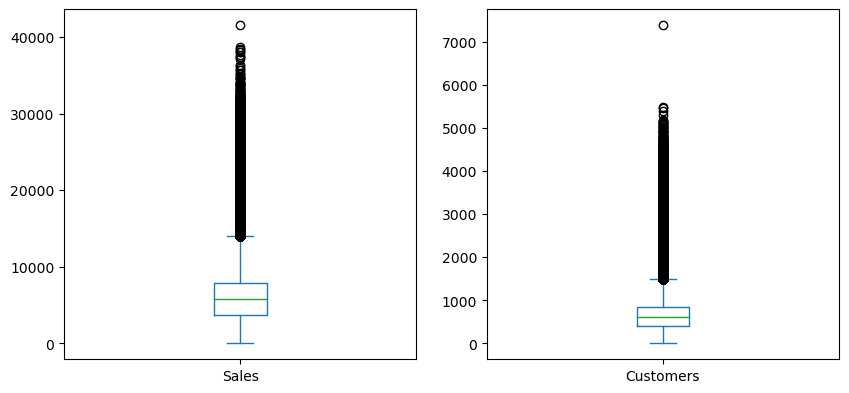

In [271]:
#Boxplot of Sales and Customers
merged_dataset.plot(y=['Sales', 'Customers'], kind='box', subplots=True, layout=(2,2), figsize=(10,10))

<AxesSubplot:xlabel='Assortment', ylabel='count'>

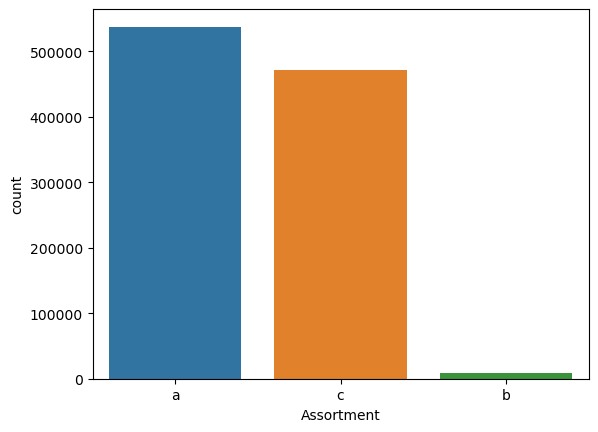

In [272]:
#Composition of 'Assortment' in the dataset
sns.countplot(data=merged_dataset,x='Assortment')

([<matplotlib.patches.Wedge at 0x7fecf5ae4850>,
 [Text(-0.14573022569430527, 1.0903039490523214, 'a'),
  Text(-0.36542502730682513, -1.0375280957245478, 'b'),
  Text(0.9543809932970793, -0.5469523924742268, 'c'),
  Text(1.098685640496396, -0.053757449409582186, 'd')],
 [Text(-0.0794892140150756, 0.5947112449376298, '54.2%'),
  Text(-0.19932274216735915, -0.5659244158497533, '30.8%'),
  Text(0.5205714508893159, -0.2983376686223055, '13.5%'),
  Text(0.5992830766343978, -0.02932224513249937, '1.6%')])

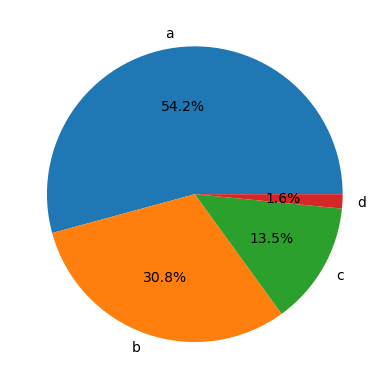

In [273]:
#Composition of 'Storetype' in the dataset
plt.pie(x=merged_dataset['StoreType'].value_counts(),labels=['a','b','c','d'],autopct='%1.1f%%')

Text(0, 0.5, 'Sales')

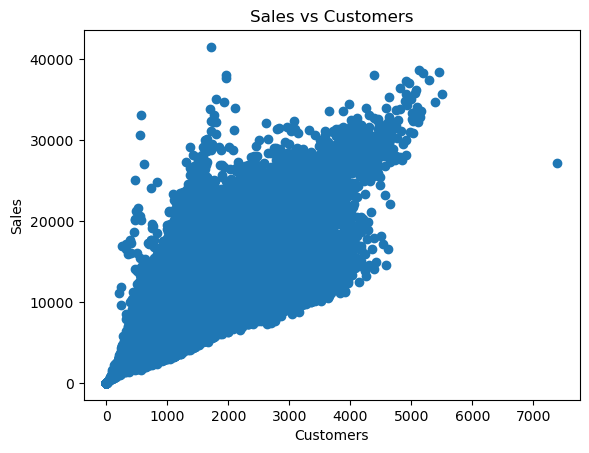

In [268]:
#Scatterplot of Sales vs customers
sales= merged_dataset['Sales']
customers = merged_dataset['Customers']
plt.scatter(customers, sales)
plt.title('Sales vs Customers')
plt.xlabel('Customers')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

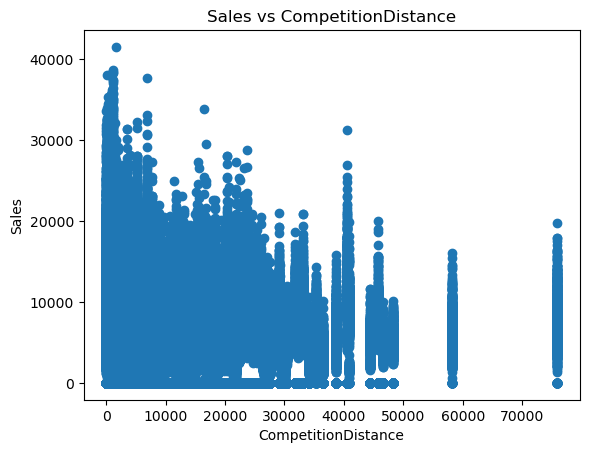

In [269]:
#Scatterplot of Sales vs Competitiondistance
sales= merged_dataset['Sales']
customers = merged_dataset['CompetitionDistance']
plt.scatter(customers, sales)
plt.title('Sales vs CompetitionDistance')
plt.xlabel('CompetitionDistance')
plt.ylabel('Sales')

In [274]:
#Store assortment avg sales table
avgsales_by_assortment = pd.pivot_table(merged_dataset, index='CurrentMonth', values='Sales', columns='Assortment', aggfunc=np.mean)

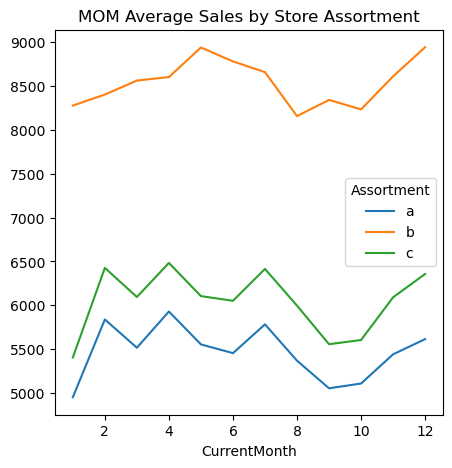

In [275]:
#Store assortment avg sales line chart
avgsales_by_assortment.plot(kind='line', title='MOM Average Sales by Store Assortment', figsize=(5,5), grid=False)
plt.show()

In [276]:
#Store type avg sales table
avgsales_by_storetype = pd.pivot_table(merged_dataset, index='CurrentMonth', values='Sales', columns='StoreType', aggfunc=np.mean)

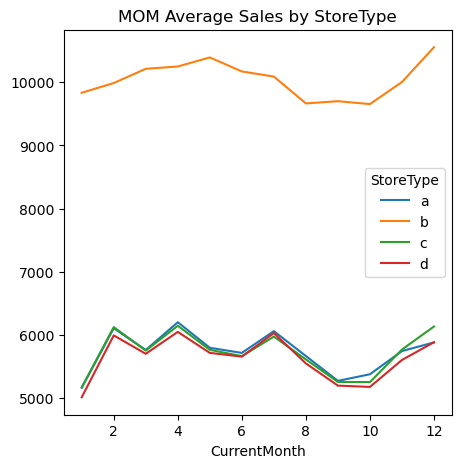

In [277]:
#Store type avg sales line chart
avgsales_by_storetype.plot(kind='line', title='MOM Average Sales by StoreType', figsize=(5,5), grid=False)
plt.show()

<AxesSubplot:xlabel='StateHoliday', ylabel='Sales'>

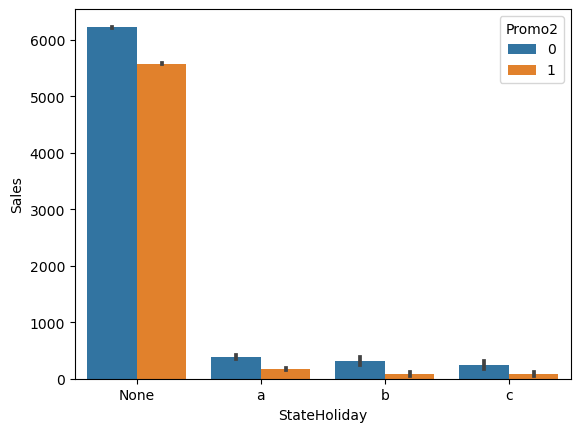

In [278]:
#Barplot of Sales by stateholiday
sns.barplot(data=merged_dataset, x="StateHoliday", y="Sales", hue="Promo2")

<AxesSubplot:xlabel='SchoolHoliday', ylabel='Sales'>

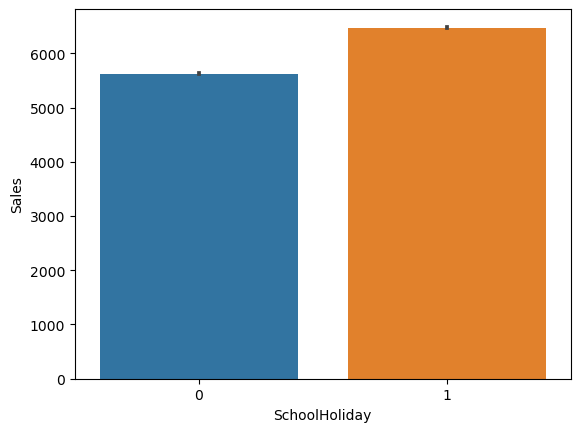

In [279]:
#Barplot of Sales by schoolholiday
sns.barplot(data=merged_dataset, x="SchoolHoliday", y="Sales")

<AxesSubplot:xlabel='StoreType', ylabel='CompetitionDistance'>

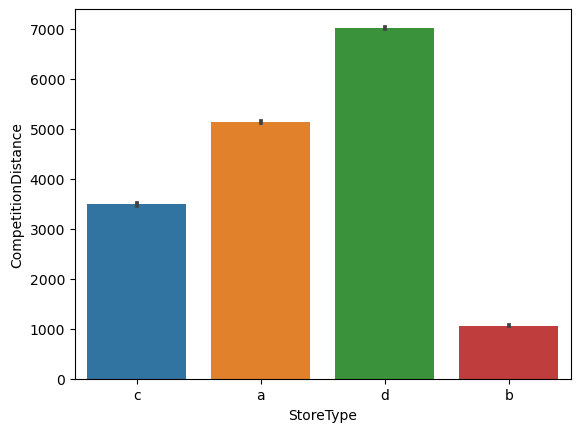

In [280]:
#Barplot of Competitiondistance by storetype
sns.barplot(data=merged_dataset, x="StoreType", y="CompetitionDistance")

# Encoding

In [317]:
#Encoding promointerval and stateholiday columns
merged_dataset['PromoInterval'].replace(['NotApplicable','Jan,Apr,Jul,Oct','Feb,May,Aug,Nov','Mar,Jun,Sept,Dec'],[0,1,2,3],inplace=True)
merged_dataset['StateHoliday'].replace(['0',0],['None','None'],inplace=True)
print(merged_dataset['PromoInterval'].unique())
print(merged_dataset['StateHoliday'].unique())

[0 1 2 3]
['None' 'a' 'b' 'c']


In [318]:
#Encoders
Onehot=OneHotEncoder(sparse=False)
Ordinal=OrdinalEncoder()

merged_dataset[['NoStateHoliday','PublicHoliday', 'EasterHoliday', 'ChristmasHoliday']] = Onehot.fit_transform(merged_dataset[['StateHoliday']])
merged_dataset[['StoreA','StoreB','StoreC','StoreD']]=Onehot.fit_transform(merged_dataset[['StoreType']])
merged_dataset[['Assortment']]=Ordinal.fit_transform(merged_dataset[['Assortment']])


In [320]:
merged_dataset[['NoStateHoliday','PublicHoliday', 'EasterHoliday', 'ChristmasHoliday','StoreA','StoreB','StoreC','StoreD','Assortment']].head()

,NoStateHoliday,PublicHoliday,EasterHoliday,ChristmasHoliday,StoreA,StoreB,StoreC,StoreD,Assortment
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Correlation Matrix

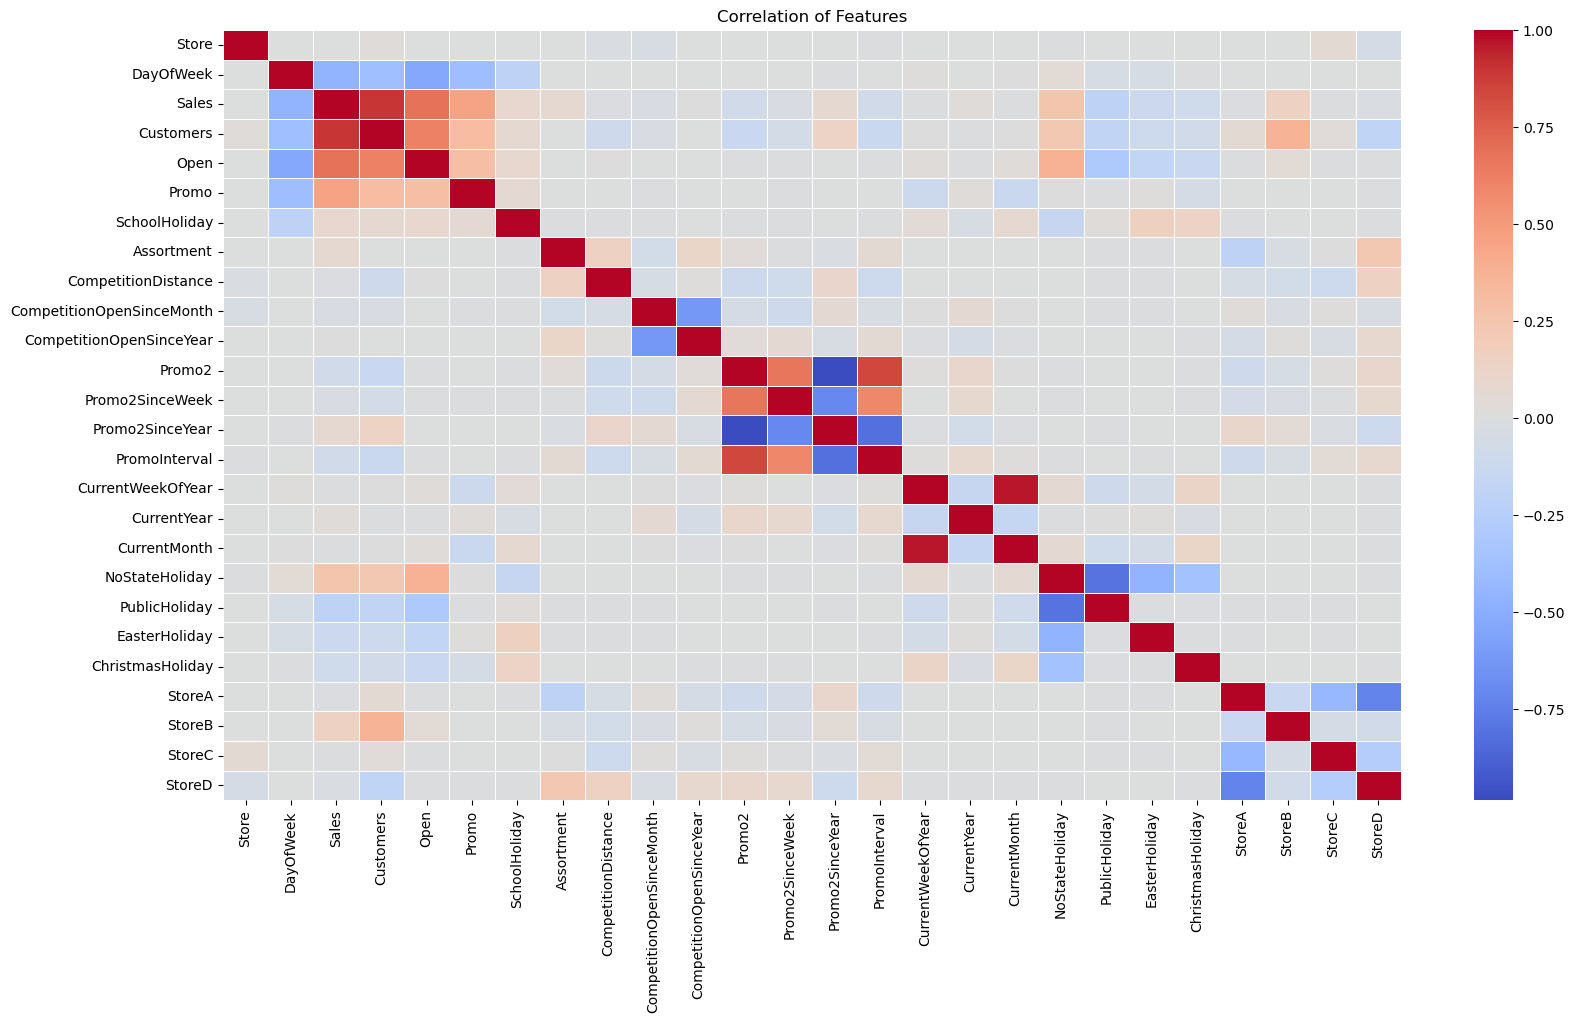

In [285]:
plt.figure(3, figsize =(19, 10))
corr_matrix = merged_dataset.corr()
sns.heatmap(corr_matrix, linewidth=0.5, cmap='coolwarm')
plt.title( "Correlation of Features" )
plt.show()

# MODEL TRAINING, ASSESSMENT AND SELECTION

In [289]:
# split into train and test sets
X = merged_dataset.drop(columns =['Sales','Date','StateHoliday','StoreType','CurrentWeekOfYear'])
y = merged_dataset[['Sales']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

## Feature Selection

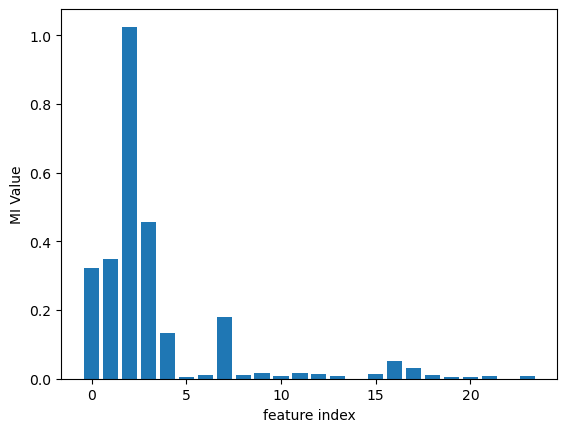

In [290]:
feature_selector = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
feature_selector.fit(X_train, y_train)
# transform train input data
X_train_fs = feature_selector.transform(X_train)
# transform test input data
X_test_fs = feature_selector.transform(X_test)
# Plot the scores for the features
plt.bar([i for i in range(len(feature_selector.scores_))], feature_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("MI Value")
plt.show()

In [291]:
#SelectKBest to get first 8
select = SelectKBest(score_func=mutual_info_regression, k=8)
z = select.fit_transform(X_train, y_train)
chosen = select.get_support()
features = X_train.columns.values
best_k = list(features[chosen])
print("Selected best 8")
print(features[chosen])
X_train = X_train[best_k]

Selected best 8
['Store' 'DayOfWeek' 'Customers' 'Open' 'Promo' 'CompetitionDistance'
 'NoStateHoliday' 'PublicHoliday']


In [292]:
#forward subset selection
model = xgb.XGBRegressor()
sfs1 = sfs(model, k_features=8, forward=True, verbose=2, scoring='r2')
sfs1 = sfs1.fit(X_train, y_train)
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.1min finished

[2023-02-10 01:13:43] Features: 1/8 -- score: 0.8437539982098798[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.6min finished

[2023-02-10 01:18:22] Features: 2/8 -- score: 0.9459845062063647[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 20.2min finished

[2023-02-10 01:38:35] Features: 3/8 -- score: 0.9588766842087197[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'CompetitionDistance', 'NoStateHoliday', 'PublicHoliday']


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished

[2023-02-10 02:40:11] Features: 8/8 -- score: 0.96888570469341

In [293]:
#selected features
feat_names = ['Store' ,'DayOfWeek' ,'Customers' ,'Open' ,'Promo' ,'CompetitionDistance'
 ,'NoStateHoliday' ,'PublicHoliday']
X_train = X_train.loc[:, feat_names]
X_test = X_test.loc[:, feat_names]

In [294]:
#selected features - excluding customers
feat_names_retrain = ['Store' ,'DayOfWeek' ,'Open' ,'Promo' ,'CompetitionDistance'
 ,'NoStateHoliday','PublicHoliday']
X_train_retrained = X_train.loc[:, feat_names_retrain]
X_test_retrained = X_test.loc[:, feat_names_retrain]

## Model Training

In [295]:
#Build model 
xgb = xgb.XGBRegressor()
xgb.fit(X_train, y_train)
score = xgb.score(X_train, y_train)  
print("Training R-Squared score: ", score)

y_test_pred = xgb.predict(X_test)
score = metrics.r2_score(y_test, y_test_pred)  
print("Test R-Squared score: ", score)

Training R-Squared score:  0.9706341157146571
Test R-Squared score:  0.9692678316597463


In [321]:
#Add columns to unseen dataset to match model
feat_names = ['Store' ,'DayOfWeek' ,'Customers' ,'Open' ,'Promo' ,'CompetitionDistance','NoStateHoliday' ,'PublicHoliday']
test[['NoStateHoliday','PublicHoliday']] = np.nan
test = test.loc[:,feat_names]
test.head()

,Store,DayOfWeek,Customers,Open,Promo,CompetitionDistance,NoStateHoliday,PublicHoliday
0,1,4,NaN,1.0,1,1270.0,NaN,NaN
1,3,4,NaN,1.0,1,14130.0,NaN,NaN
2,7,4,NaN,1.0,1,24000.0,NaN,NaN
3,8,4,NaN,1.0,1,7520.0,NaN,NaN
4,9,4,NaN,1.0,1,2030.0,NaN,NaN


In [298]:
#Show predicted values on unseen data
y_test_new = xgb.predict(test)
test['Predicted Sales'] = y_test_new
test.head()

,Store,DayOfWeek,Customers,Open,Promo,CompetitionDistance,NoStateHoliday,PublicHoliday,Predicted Sales
0,1,4,NaN,1.0,1,1270.0,NaN,NaN,-406.467133
1,3,4,NaN,1.0,1,14130.0,NaN,NaN,-97.032486
2,7,4,NaN,1.0,1,24000.0,NaN,NaN,-140.904129
3,8,4,NaN,1.0,1,7520.0,NaN,NaN,-233.556870
4,9,4,NaN,1.0,1,2030.0,NaN,NaN,168.377991


## Retraining

In [300]:
#Retrain model 
xgb_retrained = xgb.XGBRegressor()
xgb_retrained.fit(X_train_retrained, y_train)
score = xgb_retrained.score(X_train_retrained, y_train)  
print("Training R-Squared score: ", score)

y_test_pred = xgb_retrained.predict(X_test_retrained)
score = metrics.r2_score(y_test, y_test_pred)  
print("Test R-Squared score: ", score)

Training R-Squared score:  0.8533478899150325
Test R-Squared score:  0.8527154807508938


In [323]:
#Add columns to unseen dataset to match model - retrain
test_retrain = copy.deepcopy(test)
test_retrain[['NoStateHoliday','PublicHoliday']] = np.nan
test_retrain = test.loc[:,feat_names_retrain]
test_retrain

,Store,DayOfWeek,Open,Promo,CompetitionDistance,NoStateHoliday,PublicHoliday
0,1,4,1.0,1,1270.0,NaN,NaN
1,3,4,1.0,1,14130.0,NaN,NaN
2,7,4,1.0,1,24000.0,NaN,NaN
3,8,4,1.0,1,7520.0,NaN,NaN
4,9,4,1.0,1,2030.0,NaN,NaN
...,...,...,...,...,...,...,...
41083,1111,6,1.0,0,1900.0,NaN,NaN
41084,1112,6,1.0,0,1880.0,NaN,NaN
41085,1113,6,1.0,0,9260.0,NaN,NaN
41086,1114,6,1.0,0,870.0,NaN,NaN


In [324]:
#Show predicted values on unseen data - retrained
y_test_retrained = xgb_retrained.predict(test_retrain)
test_retrain['Predicted Sales'] = y_test_retrained
test_retrain.head()

,Store,DayOfWeek,Open,Promo,CompetitionDistance,NoStateHoliday,PublicHoliday,Predicted Sales
0,1,4,1.0,1,1270.0,NaN,NaN,5169.819824
1,3,4,1.0,1,14130.0,NaN,NaN,7874.095215
2,7,4,1.0,1,24000.0,NaN,NaN,9648.726562
3,8,4,1.0,1,7520.0,NaN,NaN,7052.882812
4,9,4,1.0,1,2030.0,NaN,NaN,6963.276855


# END